In [1]:
import timm
import numpy as np
import torch
import torchvision
import pickle
import math
from tqdm import tqdm
from typing import Callable, Iterator, List, Tuple
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from sklearn.metrics import mean_absolute_error, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import cv2
import os
import torch.nn.functional as F
from PIL import Image
from pathlib import Path
from matplotlib.colors import ListedColormap
from torchvision.models.feature_extraction import get_graph_node_names
import copy


In [5]:
model = timm.create_model("hf_hub:anonauthors/dtd-timm-convnext_base.fb_in1k", pretrained=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RAdam(model.parameters(), lr=0.001)
model.eval()

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (

In [6]:
from timm.models.layers import trunc_normal_, DropPath

class Block(nn.Module):
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim) # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim)), 
                                    requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x

class ConvNeXt(nn.Module):
    def __init__(self, in_chans=3, num_classes=num_classes, 
                 depths=[3, 3, 9, 3], dims=[192, 384, 768, 1024], drop_path_rate=0., 
                 layer_scale_init_value=1e-6, head_init_scale=1.,
                 ):
        super().__init__()

        self.downsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                    LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList() # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates=[x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))] 
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_path=dp_rates[cur + j], 
                layer_scale_init_value=layer_scale_init_value) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6) # final norm layer
        self.head = nn.Linear(dims[-1], num_classes)

        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)
        self.stored_gradients = None  # Tensor to store gradients

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def save_gradients(self, grad):
        self.stored_gradients = grad  # Store gradients as tensor

    def get_activations_gradient(self):
        return self.stored_gradients  # Return the stored gradients
    
    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(x.mean([-2, -1])) # global average pooling, (N, C, H, W) -> (N, C)
    
    def get_activations(self, x):
        activations = []
        for i in range(4):  # Assuming there are 4 downsampling layers
            x = self.downsample_layers[i](x)
            if i == 3:
                activations.append(x.clone().detach())  # Clone and detach to avoid modifying original gradients
            x = self.stages[i](x)
        return activations
    
    def forward(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            if i == 3:  # Register hook on the output tensor of the last convolutional layer
                x.register_hook(self.save_gradients)
            x = self.stages[i](x)
        x = self.norm(x.mean([-2, -1])) # global average pooling, (N, C, H, W) -> (N, C)
        x = self.head(x)
        return x
    
    # def attach_last_conv_hook(self):
    #     # Attach the hook to the last convolutional layer in downsample_layers
    #     last_conv_layer = self.downsample_layers[-1][-1] # Assuming the last element in downsample_layer is the last conv layer
    #     last_conv_layer.register_hook(self.save_gradients)
        
class LayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError 
        self.normalized_shape = (normalized_shape, )
    
    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x


In [7]:
custom_model = ConvNeXt().to(device)

# Load pretrained weights
pre_trained_model = 'anonauthors/dtd-timm-convnext_base.fb_in1k'
pretrained_state_dict = torch.hub.load_state_dict_from_url(
        f'https://huggingface.co/{pre_trained_model}/resolve/main/pytorch_model.bin'
    )
custom_model.load_state_dict(pretrained_state_dict, strict=False)

_IncompatibleKeys(missing_keys=['downsample_layers.0.0.weight', 'downsample_layers.0.0.bias', 'downsample_layers.0.1.weight', 'downsample_layers.0.1.bias', 'downsample_layers.1.0.weight', 'downsample_layers.1.0.bias', 'downsample_layers.1.1.weight', 'downsample_layers.1.1.bias', 'downsample_layers.2.0.weight', 'downsample_layers.2.0.bias', 'downsample_layers.2.1.weight', 'downsample_layers.2.1.bias', 'downsample_layers.3.0.weight', 'downsample_layers.3.0.bias', 'downsample_layers.3.1.weight', 'downsample_layers.3.1.bias', 'stages.0.0.gamma', 'stages.0.0.dwconv.weight', 'stages.0.0.dwconv.bias', 'stages.0.0.norm.weight', 'stages.0.0.norm.bias', 'stages.0.0.pwconv1.weight', 'stages.0.0.pwconv1.bias', 'stages.0.0.pwconv2.weight', 'stages.0.0.pwconv2.bias', 'stages.0.1.gamma', 'stages.0.1.dwconv.weight', 'stages.0.1.dwconv.bias', 'stages.0.1.norm.weight', 'stages.0.1.norm.bias', 'stages.0.1.pwconv1.weight', 'stages.0.1.pwconv1.bias', 'stages.0.1.pwconv2.weight', 'stages.0.1.pwconv2.bias', 

In [21]:
def generate_heatmap(model, img):
    print(img.shape)
    pred = model(img)
    dimension = int(pred.argmax(dim=1)[0])
    pred[:, dimension].backward()
    gradients = model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=(0, 2, 3))
    activations = custom_model.get_activations(img)
    pooled_gradients = pooled_gradients.detach()
    activations = model.get_activations(img)
    for i in range(len(activations)):
        activations[i] = activations[i].detach() * pooled_gradients[i] 
    stacked_activations = torch.stack(activations)  # Stack the tensors
    heatmap = torch.mean(stacked_activations, dim=1).squeeze()
    heatmap = torch.clamp(heatmap, min=0)  # Ensure non-negative values
    heatmap /= torch.max(heatmap)  # Normalize
    return heatmap

def save_heatmap(heatmap, idx, output_folder):
    heatmap = heatmap.cpu()
    plt.matshow(heatmap.squeeze())
    plt.close()

def superimpose_and_save(heatmap, img):
    heatmap = torch.mean(heatmap, dim=0).squeeze().cpu().numpy()  # Shape: (7, 7)
    img = img.squeeze(0)
    img = img.permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C)
    # Normalize heatmap to [0, 255] and convert to uint8

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap)))
    
    # Ensure img is in range [0, 255] and convert to uint8
    img = np.uint8(255 * (img - np.min(img)) / (np.max(img) - np.min(img)))
    # Apply color map to heatmap
    heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    # Superimpose heatmap on image
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)
    # Save the superimposed image
    plt.axis(False)
    plt.imshow(superimposed_img)
    return heatmap_colored

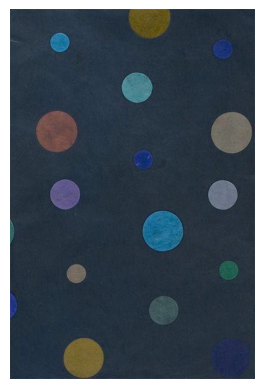

In [62]:
img_path = "dotted_0166.jpg"
img = cv2.imread(img_path)
plt.axis(False)
plt.imshow(img)

In [63]:
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

img = data_transforms(img)

num_classes = 47

torch.Size([1, 3, 224, 224])


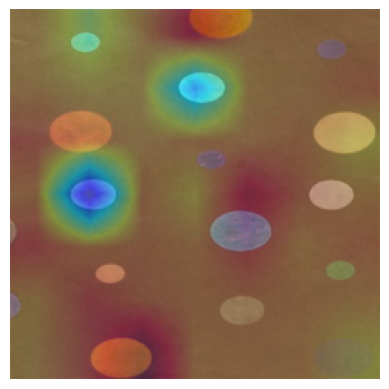

In [64]:
custom_model.eval()
img = img.unsqueeze(0).to(device)
with torch.enable_grad():
    heatmap = generate_heatmap(custom_model, img)
    # save_heatmap(heatmap, idx, output_folder)
    heatmap = superimpose_and_save(heatmap, img)
    

In [54]:
def perturb_image(image, heatmap, percentage, mode='zero'):
    flat_heatmap = heatmap.flatten()
    indices = torch.argsort(-flat_heatmap)  
    perturbed_image = image.clone().detach()  
    num_pixels_to_perturb = int(percentage * flat_heatmap.numel()) 
    if mode == 'zero':
        perturbed_image.view(-1)[indices[:num_pixels_to_perturb]] = 0
    elif mode == 'mean':
        mean_value = torch.mean(image, dim=[1, 2])
        for c in range(3):  
            perturbed_image[c].view(-1)[indices[:num_pixels_to_perturb]] = mean_value[c]

    return perturbed_image


In [65]:
def compute_aopc_and_capture_details(model, heatmap, device, steps=10):
    perturbation_details = []
    total_aopc = 0.0
    total_images = 0

    max_batches = 3  # You stop after 3 iterations
    current_batch = 0

    inputs = img.to(device)
    original_outputs = model(inputs).detach()
    original_confidence = torch.nn.functional.softmax(original_outputs, dim=1).max(dim=1)[0]

    heatmap = torch.tensor(heatmap).to(device)  # Ensure heatmap is on the correct device

    confidences = [original_confidence.item()]

    for step in range(1, steps + 1):
        percentage = step / steps
        perturbed_image = perturb_image(img.cpu(), heatmap, percentage).to(device)
        perturbed_output = model(perturbed_image).detach()
        perturbed_confidence = torch.nn.functional.softmax(perturbed_output, dim=1).max(dim=1)[0]
        confidences.append(perturbed_confidence.item())

    perturbation_details.append(confidences)
    aopc = (confidences[0] - confidences[-1]) / steps
    total_aopc += aopc
    total_images += 1

    current_batch += 1

    average_aopc = total_aopc / total_images if total_images > 0 else 0
    return average_aopc, perturbation_details


In [66]:

def plot_aopc_results(perturbation_details):
    # Calculate average confidence at each perturbation step
    steps = len(perturbation_details[0])
    average_confidences = [0] * steps
    for details in perturbation_details:
        for i in range(steps):
            average_confidences[i] += details[i]
    average_confidences = [x / len(perturbation_details) for x in average_confidences]

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.plot(range(steps), average_confidences, marker='o', linestyle='-', color='b')
    plt.title('Average Model Confidence vs. Perturbation Steps')
    plt.xlabel('Perturbation Step')
    plt.ylabel('Average Confidence')
    plt.grid(True)
    plt.show()


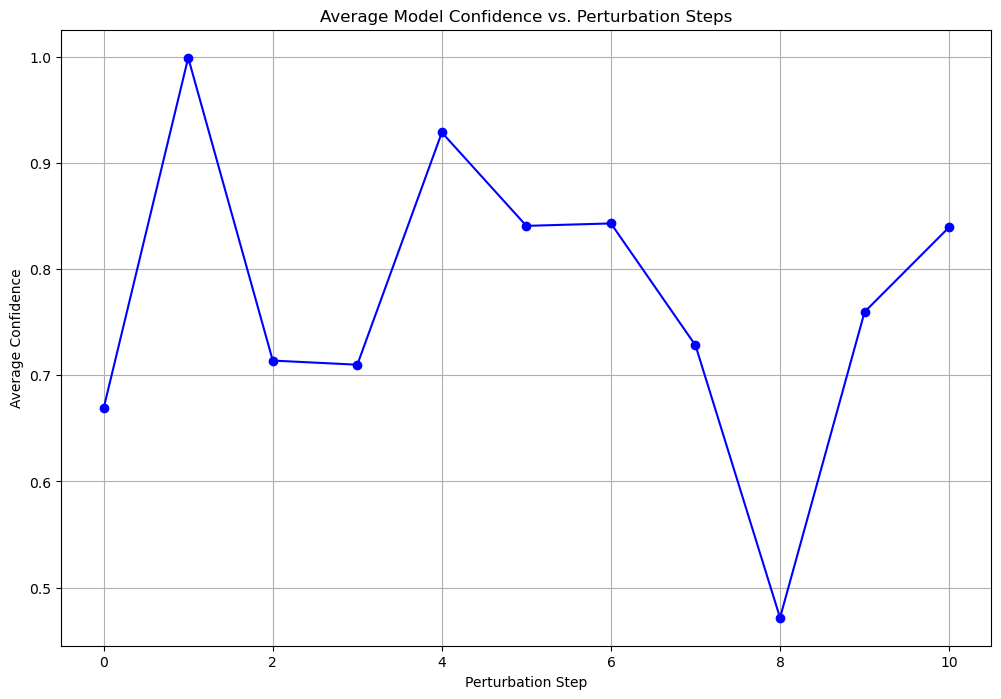

In [67]:
average_aopc, details = compute_aopc_and_capture_details(model, heatmap, device)
plot_aopc_results(details)

In [91]:
def pre_processing(obs, device):
    mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
    std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
    obs = obs / 255
    obs = (obs - mean) / std
    obs = np.transpose(obs, (2, 0, 1))
    obs = np.expand_dims(obs, 0)
    obs = np.array(obs)
    obs_tensor = torch.tensor(obs, dtype=torch.float32, device=device, requires_grad=True)
    return obs_tensor

In [92]:
def preprocess_image_eval(image, device):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    image = image.to(device)  
    image = normalize(image) 
    return image.unsqueeze(0) 

In [87]:
def calculate_outputs_and_gradients_eval(inputs, model, target_label_idx, device):
    # do the pre-processing
    predict_idx = None
    gradients = []
    for input in inputs:
        input = input.cpu()
        input = preprocess_image_eval(input, device)
        input.requires_grad_(True)
        input.to(device)
        output = model(input)
        if target_label_idx is None:
            target_label_idx = torch.argmax(output, 1).item()
        output = F.softmax(output, dim=1)
        index = np.ones((output.size()[0], 1)) * target_label_idx
        index = torch.tensor([[target_label_idx]], dtype=torch.int64, device=device)
        output = output.gather(1, index)
        # clear grad
        model.zero_grad()
        output.backward()
        gradient = input.grad.detach().cpu().numpy()[0]
        gradients.append(gradient)
    gradients = np.array(gradients)
    return gradients, target_label_idx

In [95]:
def integrated_gradients_eval(inputs, model, target_label_idx, predict_and_gradients, baseline=None, steps=50, device="cpu"):
    if baseline is None:
        baseline = 0 * inputs 
    inputs = inputs.to(device)
    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(0, steps + 1)]
    grads, _ = predict_and_gradients(scaled_inputs, model, target_label_idx, device)
    avg_grads = np.average(grads[:-1], axis=0)
    avg_grads = np.transpose(avg_grads, (1, 2, 0))
    delta_X = (pre_processing(inputs, device) - pre_processing(baseline, device)).detach().squeeze(0).cpu().numpy()
    delta_X = np.transpose(delta_X, (1, 2, 0))
    integrated_grad = delta_X * avg_grads
    return integrated_grad

def random_baseline_integrated_gradients_eval(inputs, model, target_label_idx, predict_and_gradients, steps, num_random_trials, device):
    all_intgrads = []
    for i in range(num_random_trials):
        integrated_grad = integrated_gradients_eval(inputs, model, target_label_idx, predict_and_gradients, \
                                                baseline=255.0 *np.random.random(inputs.shape), steps=steps, device=device)
        all_intgrads.append(integrated_grad)
        # print('the trial number is: {}'.format(i))
    avg_intgrads = np.average(np.array(all_intgrads), axis=0)
    return avg_intgrads

In [71]:
def generate_entrie_images(img_origin, img_integrad, img_integrad_overlay):
    blank = np.ones((img_origin.shape[0], 10, 3), dtype=np.uint8) * 255
    # blank_hor = np.ones((10, 20 + img_grad.shape[0] * 3, 3), dtype=np.uint8) * 255
    # upper = np.concatenate([img_origin[:, :, (2, 1, 0)], blank, img_grad_overlay, blank, img_grad], 1)
    down = np.concatenate([img_origin[:, :, (2, 1, 0)], blank, img_integrad_overlay, blank, img_integrad], 1)
    # print(upper.shape, blank_hor.shape, down.shape)
    total = np.concatenate([down], 0)
    total = cv2.resize(total, (550, 182))

    return total

In [72]:
G = [0, 255, 0]
R = [255, 0, 0]

def convert_to_gray_scale(attributions):
    return np.average(attributions, axis=2)

In [73]:
def compute_threshold_by_top_percentage(attributions, percentage=60, plot_distribution=True):
    if percentage < 0 or percentage > 100:
        raise ValueError('percentage must be in [0, 100]')
    if percentage == 100:
        return np.min(attributions)
    flat_attributions = attributions.flatten()
    attribution_sum = np.sum(flat_attributions)
    sorted_attributions = np.sort(np.abs(flat_attributions))[::-1]
    cum_sum = 100.0 * np.cumsum(sorted_attributions) / attribution_sum
    threshold_idx = np.where(cum_sum >= percentage)[0][0]
    threshold = sorted_attributions[threshold_idx]
    if plot_distribution:
        raise NotImplementedError 
    return threshold


In [74]:
def linear_transform(attributions, clip_above_percentile=99.9, clip_below_percentile=70.0, low=0.2, plot_distribution=False):
    m = compute_threshold_by_top_percentage(attributions, percentage=100-clip_above_percentile, plot_distribution=plot_distribution)
    e = compute_threshold_by_top_percentage(attributions, percentage=100-clip_below_percentile, plot_distribution=plot_distribution)
    transformed = (1 - low) * (np.abs(attributions) - e) / (m - e) + low
    transformed *= np.sign(attributions)
    transformed *= (transformed >= low)
    transformed = np.clip(transformed, 0.0, 1.0)
    return transformed


In [75]:
def polarity_function(attributions, polarity):
    if polarity == 'positive':
        return np.clip(attributions, 0, 1)
    elif polarity == 'negative':
        return np.clip(attributions, -1, 0)
    else:
        raise NotImplementedError

def overlay_function(attributions, image):
    return np.clip(0.7 * image + 0.5 * attributions, 0, 255)

In [76]:
def visualize(attributions, image, positive_channel=G, negative_channel=R, polarity='positive', \
                clip_above_percentile=99.9, clip_below_percentile=0, morphological_cleanup=False, \
                structure=np.ones((3, 3)), outlines=False, outlines_component_percentage=90, overlay=True, \
                mask_mode=False, plot_distribution=False):
    if polarity == 'both':
        raise NotImplementedError

    elif polarity == 'positive':
        attributions = polarity_function(attributions, polarity=polarity)
        channel = positive_channel
    
    attributions = convert_to_gray_scale(attributions)
    attributions = linear_transform(attributions, clip_above_percentile, clip_below_percentile, 0.0, plot_distribution=plot_distribution)
    attributions_mask = attributions.copy()
    attributions = torch.tensor(attributions, dtype=torch.float32)
    if morphological_cleanup:
        raise NotImplementedError
    if outlines:
        raise NotImplementedError
    if isinstance(attributions, np.ndarray):
        attributions = torch.tensor(attributions, dtype=torch.float32).to(image.device)
    attributions = np.expand_dims(attributions, 2) * channel
    if overlay:
        if not mask_mode:
            attributions = overlay_function(attributions, image)
        else:
            attributions = np.expand_dims(attributions_mask, 2)             
            attributions = np.clip(attributions * image, 0, 255)
            attributions = attributions[:, :, [2, 1, 0]]
    
    return attributions

In [89]:
img = cv2.imread(img_path)
img = data_transforms(img)


In [97]:
processed_img = preprocess_image_eval(img, device)
gradients, label_index = calculate_outputs_and_gradients_eval(processed_img, model, None, device)
attributions = random_baseline_integrated_gradients_eval(processed_img, model, label_index, calculate_outputs_and_gradients_eval, steps=50, num_random_trials=10, device='cpu')
img_integrated_gradient = visualize(attributions, processed_img, clip_above_percentile=99, clip_below_percentile=0, overlay=False)

TypeError: Concatenation operation is not implemented for NumPy arrays, use np.concatenate() instead. Please do not rely on this error; it may not be given on all Python implementations.